In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import zeus.notebook_utils.syspath as syspath
syspath.add_parent_folder()

In [2]:
import os
import torch
from zeus.core.random import super_seed
from zeus.torch_tools.checkpoints import find_latest_dir
from zeus.utils import TimestampFormat

In [3]:
from kidney.datasets.kaggle import get_reader
from kidney.datasets.offline import create_data_loaders
from kidney.datasets.utils import read_segmentation_info
from kidney.experiments.smp import SMPExperiment, parse_fold_keys
from kidney.utils.checkpoints import CheckpointsStorage, load_experiment

# Computing metrics on checkpoints

In [4]:
CHECKPOINTS = "/home/ck/experiments/smp/checkpoints/"

In [5]:
reader = get_reader()

In [6]:
storage = CheckpointsStorage(CHECKPOINTS)

In [7]:
benchmark = storage.fetch_available_checkpoints("avg_val_loss", best_checkpoint_per_date=False)[-1]

In [8]:
checkpoint_files, meta_file = benchmark["checkpoints"], benchmark["meta"]

In [38]:
import ast
import re
from typing import Any, Dict, Type
from zeus.utils import named_match

def parse_string(filename: str, patterns: Dict) -> Dict[str, Any]:
    entries = []
    for name, template in patterns.items():
        if template is int or template is float:
            template = {int: r"\d+", float: r"\d+.\d+"}[template]
        entries.append(fr"{name}=(?P<{name}>{template})")
    regex = "_".join(entries)
    return named_match(pattern=regex, string=filename)

In [10]:
assert (
    parse_string("epoch=14_avg_val_loss=0.0403.ckpt", {'epoch': r'\d+', 'avg_val_loss': r'\d+.\d+'}) ==
    {'epoch': 14, 'avg_val_loss': 0.0403}
)

In [11]:
device = torch.device("cuda:0")

In [12]:
total = len(checkpoint_files)

In [13]:
from operator import itemgetter

sorted_files = [
    filename
    for filename, _ in 
    sorted([
        (fn, parse_string(fn, {"epoch": int})["epoch"]) 
        for fn in checkpoint_files
    ], key=itemgetter(1))
]

In [ ]:
metrics_per_checkpoint = []

for i, checkpoint_file in enumerate(sorted_files):
    print(f"[{i+1:3d}/{total:3d}] inference: {checkpoint_file}")
    
    experiment, meta = load_experiment(SMPExperiment, checkpoint_file, meta_file)

    experiment.to(device)
    params = meta["params"]
    super_seed(params.seed)
    
    loaders = create_data_loaders(
        reader=reader,
        valid_keys=parse_fold_keys(params.fold) if params.fold is not None else params.fold,
        transformers=meta["transformers"],
        samples=read_segmentation_info(params.dataset, file_format=params.file_format),
        num_workers=params.num_workers,
        batch_size=params.batch_size,
        multiprocessing_context=params.data_loader_multiprocessing_context
    )
        
    with torch.no_grad():
        metrics = {"train": [], "valid": []}
        for name, loader in loaders.items():
            for batch in loader:
                batch = {key: tensor.to(device) for key, tensor in batch.items()}
                outputs = experiment(batch)
                batch_metrics = {
                    metric.name.replace(' ', '_'): metric(outputs, batch).item() 
                    for metric in experiment.metrics
                }
                metrics[name].append(batch_metrics)
                
    metrics_per_checkpoint.append({
        "order": i, 
        "filename": checkpoint_file, 
        "batch_metrics": metrics
    })
            
    del experiment, loaders

[  1/100] inference: /home/ck/experiments/smp/checkpoints/Sun_28_Feb__20_18_24/epoch=0_avg_val_loss=0.6191.ckpt


In [ ]:
torch.save(metrics_per_checkpoint, "/home/ck/benchmark.pth")

# Loading saved benchmark

In [44]:
from collections import defaultdict, OrderedDict
import numpy as np
import pandas as pd

In [5]:
benchmark = torch.load("/home/ck/benchmark.pth")

In [47]:
table = []
for checkpoint in benchmark:
    metrics = checkpoint["batch_metrics"]
    from_file = parse_string(checkpoint["filename"], {"avg_val_loss": float})
    record = OrderedDict()
    record["order"] = checkpoint["order"]
    record["avg_val_loss"] = from_file["avg_val_loss"]
    for subset in metrics.keys():
        collected = defaultdict(list)
        for batch in metrics[subset]:
            for metric, value in batch.items():
                collected[metric].append(value)
        avg, std = {}, {}
        for name, values in collected.items():
            avg[name], std[name] = np.mean(values), np.std(values)        
        record.update([(f"{subset}_mean_{k}", v) for k, v in avg.items()])
        record.update([(f"{subset}_std_{k}", v) for k, v in std.items()])
    table.append(record)

In [48]:
df = pd.DataFrame(table)

In [49]:
df

,order,avg_val_loss,train_mean_dice,train_mean_recall,train_mean_precision,train_mean_accuracy,train_mean_balanced_accuracy,train_std_dice,train_std_recall,train_std_precision,...,valid_mean_dice,valid_mean_recall,valid_mean_precision,valid_mean_accuracy,valid_mean_balanced_accuracy,valid_std_dice,valid_std_recall,valid_std_precision,valid_std_accuracy,valid_std_balanced_accuracy
0,0,0.6191,0.115145,0.276942,0.276942,0.276942,0.276942,0.031730,0.064506,0.064506,...,0.150204,0.448046,0.448046,0.448046,0.448046,0.028964,0.016085,0.016085,0.016085,0.016085
1,1,0.5433,0.191251,0.357105,0.357105,0.357105,0.357105,0.052814,0.084729,0.084729,...,0.187186,0.353383,0.353383,0.353383,0.353383,0.032855,0.035590,0.035590,0.035590,0.035590
2,2,0.4625,0.357404,0.557278,0.557278,0.557278,0.557278,0.090006,0.129075,0.129075,...,0.485637,0.705675,0.705675,0.705675,0.705675,0.102279,0.054156,0.054156,0.054156,0.054156
3,3,0.3505,0.450748,0.567395,0.567395,0.567395,0.567395,0.107758,0.136324,0.136324,...,0.605885,0.748014,0.748014,0.748014,0.748014,0.133513,0.054516,0.054516,0.054516,0.054516
4,4,0.2775,0.474266,0.565254,0.565254,0.565254,0.565254,0.113070,0.140921,0.140921,...,0.623576,0.730308,0.730308,0.730308,0.730308,0.139308,0.061497,0.061497,0.061497,0.061497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.0293,0.616119,0.648789,0.648789,0.648789,0.648789,0.114673,0.141981,0.141981,...,0.779314,0.859297,0.859297,0.859297,0.859297,0.128760,0.053918,0.053918,0.053918,0.053918
96,96,0.0299,0.615309,0.646885,0.646885,0.646885,0.646885,0.115379,0.142474,0.142474,...,0.776539,0.856781,0.856781,0.856781,0.856781,0.129202,0.053713,0.053713,0.053713,0.053713
97,97,0.0295,0.616184,0.648846,0.648846,0.648846,0.648846,0.114922,0.142293,0.142293,...,0.778136,0.859580,0.859580,0.859580,0.859580,0.129091,0.053908,0.053908,0.053908,0.053908
98,98,0.0298,0.615873,0.648021,0.648021,0.648021,0.648021,0.115340,0.142603,0.142603,...,0.778135,0.858487,0.858487,0.858487,0.858487,0.128792,0.053787,0.053787,0.053787,0.053787


<AxesSubplot:>

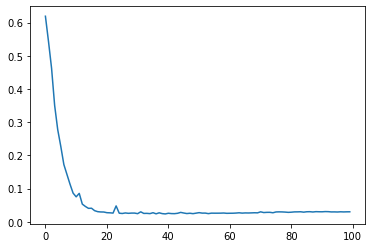

In [50]:
df.avg_val_loss.plot()

<AxesSubplot:xlabel='order'>

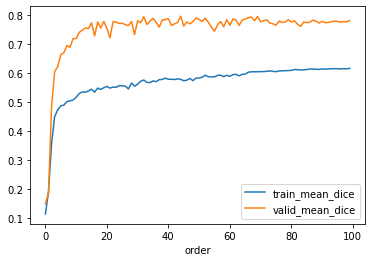

In [52]:
df.plot(x="order", y=["train_mean_dice", "valid_mean_dice"])